In [0]:
import sys
import os
import numpy as np
import glob
import argparse

from keras import backend as K
from keras import __version__
import cv2

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras import optimizers
from keras import callbacks
from keras.regularizers import l2,l1
from keras.preprocessing import image

from PIL import Image

import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [0]:
images_folder = './images/'
out_folder= './visualizations/'
model_weights_path='./model/black_models_15epochs_weights.h5'

In [0]:
# Teacher/Student graph.
# Teacher ---> Decoder ---> Student
def build_graph(input_shape = (224,224,3),nbr_of_classes=38,view_summary=False):
#Teacher's graph.
    base_model1 = VGG16(include_top=False, weights='imagenet',input_shape = input_shape)
    x1_0 = base_model1.output
    x1_0 = Flatten(name='Flatten1')(x1_0)
    x1_1 = Dense(256, name='fc1',activation='relu')(x1_0) 
    x1_2 = classif_out_encoder1 = Dense(nbr_of_classes, name='out1', activation = 'softmax')(x1_1)  
#Decoder's graph.	
	#Get Teacher's tensors for skip connection.
    pool5 = base_model1.get_layer('block5_pool').output
    conv5 = base_model1.get_layer('block5_conv3').output
    conv4 = base_model1.get_layer('block4_conv3').output
    conv3 = base_model1.get_layer('block3_conv3').output
    conv2 = base_model1.get_layer('block2_conv2').output
    conv1 = base_model1.get_layer('block1_conv2').output
	#Inverse fully connected Teacher's layers. 
    inv_x1_1 = Dense(256, name='inv_x1_1',activation='relu')(x1_2)
    merge_x1_1 = Add(name='merge_x1_1')([inv_x1_1,x1_1])
    inv_x1_0 = Dense(7*7*512, name='x1_1',activation='relu')(merge_x1_1)
    reshaped_inv_x1_0 = Reshape((7, 7,512), name='')(inv_x1_0)
    inv_x1_0 = Add(name='merge_x1_0')([reshaped_inv_x1_0,pool5])
    #DECONV Block1
    up7 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(inv_x1_0))
    merge7 = concatenate([conv5,up7], axis = 3)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    #DECONV Block2
    up8 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv4,up8], axis = 3)
    conv8 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    #DECONV Block13
    up9 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv3,up9], axis = 3)
    conv9 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #DECONV Block14
    up10 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
    merge10 = concatenate([conv2,up10], axis = 3)
    conv10 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
    conv10 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
	#DECONVBlock15
    up11 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
    merge11 = concatenate([conv1,up11], axis = 3)
    conv11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11)
    conv11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    #Reconstructed image refinement
    conv11 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    mask = conv11 = Conv2D(3, 1, activation = 'sigmoid',name='Mask')(conv11)
    
#Graphe of Student
    base_model2 = VGG16(include_top=False, weights='imagenet',input_shape = (224,224,3))
    x2_0 = base_model2(mask)
    x2_0 = Flatten(name='Flatten2')(x2_0)
    x2_1 = Dense(256, name='fc2',activation='relu')(x2_0) 
    classif_out_encoder2  = Dense(nbr_of_classes, name='out2',activation='softmax')(x2_1)
  
#Get Teacher/Student Model
    model = Model(input = base_model1.input, output = [classif_out_encoder1,classif_out_encoder2])
    if(view_summary):
	    print(mode.summary())
#Compile the mode to use multi-task learning
    losses = {
            "out1": 'categorical_crossentropy',
            "out2": 'categorical_crossentropy'
            }
    alpha=0.4
    lossWeights = {"out1": alpha, "out2": (1.0-alpha)}
    model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss=losses, loss_weights=lossWeights,metrics = ['accuracy'])
  
    return model


In [0]:
def preprocess_image(image_path,image_size = (224,224)):
    original_image = image.load_img(image_path , target_size=image_size)
    img = image.img_to_array(original_image)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return original_image,img

def build_visualization(model_weights_path):
    model = build_graph()
    model.load_weights(model_weights_path)
    layer_name ='Mask'
    NewInput = model.get_layer(layer_name).output
    visualization = K.function([model.input], [NewInput])
    return visualization,model

def reduce_channels_sequare(heatmap):
    channel1 = heatmap[:,:,0]
    channel2 = heatmap[:,:,1]
    channel3 = heatmap[:,:,2]
    new_heatmap = np.sqrt((channel1*channel1)+(channel2*channel2)+(channel3*channel3)) 
    return new_heatmap
	
def postprocess_vis(heatmap1,threshould = 0.9):
    heatmap=heatmap1.copy()
    heatmap = (heatmap - heatmap.min())/(heatmap.max() - heatmap.min())
    heatmap = reduce_channels_sequare(heatmap)
    heatmap = (heatmap - heatmap.min())/(heatmap.max() - heatmap.min())
    heatmap[heatmap<=threshould] = 0
    heatmap = heatmap*255
    return heatmap

def visualize_image(visualization,image_path,out_folder):
    base=os.path.basename(image_path)
    image_name= os.path.splitext(base)[0]
    original_image,img = preprocess_image(image_path)
    vis = visualization([img])[0][0]
    
    '''
    c1 =vis[:,:,0]
    c2 =vis[:,:,1]
    c3 =vis[:,:,2]

    vis[:,:,0] = c3
    vis[:,:,1] = c2
    vis[:,:,2] = c1
    '''
    
    heatmap = postprocess_vis(vis)
    
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(original_image)
    axarr[1].imshow(vis)
    axarr[2].imshow(heatmap,cmap='Reds')
    
    plt.show()
    
    
def visualize_folder(visualization,images_folder,out_folder):	
    if not os.path.exists(out_folder):
        os.makedirs(out_folde)
    for path in os.listdir(images_folder):
		    print(path)
		    image_path = os.path.join(images_folder,path)
		    visualize_image(visualization,image_path,out_folder)

In [0]:
visualization,model = build_visualization(model_weights_path)
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

3.jpg


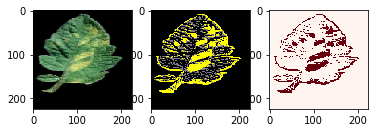

1.jpg


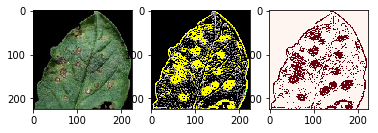

4.jpg


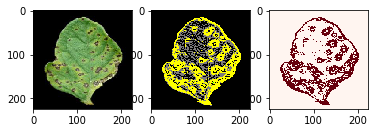

2.jpg


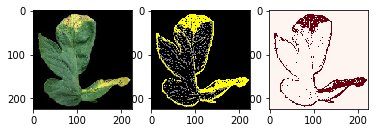

In [0]:
visualize_folder(visualization,images_folder,out_folder)

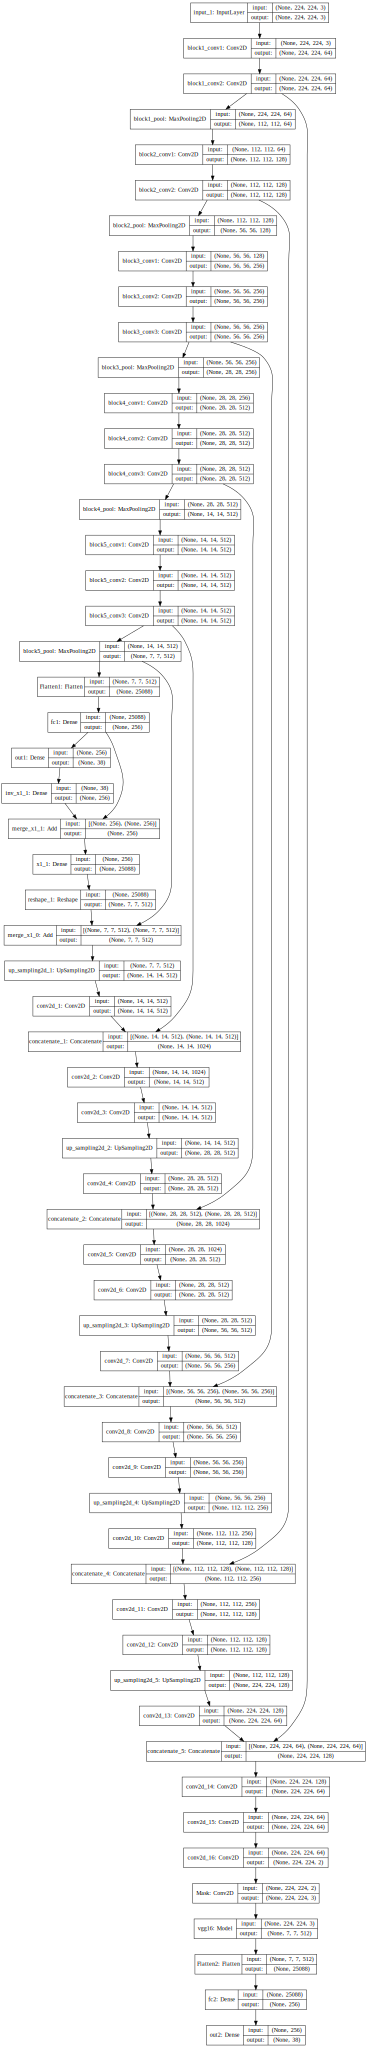

In [0]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))